In [1]:
import msprime, tskit, time, tsinfer
import numpy as np
from IPython.display import SVG
import plotly.graph_objects as go
# from algorithm._metric_ import (node_tree_discrepancy, discrepancy)
import tsdate
import plotly.io
from tqdm import tqdm
from plotly.subplots import make_subplots
from tqdm import tqdm
from time import time

In [2]:
colors = {'blue': 'rgb(46,37,133)',
          'red': 'rgb(194,106,119)',
          'lgreen': 'rgb(93,168,153)',
          'gold': 'rgb(220,205,125)',
          'green': 'rgb(51, 117,56)',
          
          'lblue': 'rgb(148,203,236)',
          'magenta': 'rgb(159,74,150)',
          'wine': 'rgb(126,041,084)', 
         }

### The Truth
The following will be our final images, and data collection for how the `extend_edges` method compares to other methods/packages including `tsinfer` and `keep_unary`.

We first will generate a tree sequence which will serve as our 'ground truth'. 
Then using `simplify` we can then simplify this tree sequence using `TSkit` and then we extend the simplified tree sequence and compare.

In [3]:
ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e6, recombination_rate=1e-8,
                         record_full_arg=True)
# SVG(ts.draw_svg(size=(2000, 500), x_lim=[0, 5e4]))

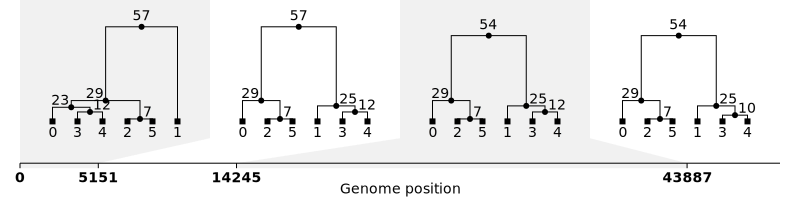

In [4]:
sts = ts.simplify()
uts = ts.simplify(keep_unary=True)
SVG(sts.draw_svg(x_lim=[0, 5e4]))

Currently, we still have `extend_edges` output a bunch of print statements. We should fix that so it stops.

In [4]:
eets = sts.extend_edges()
epts = sts.extend_paths()

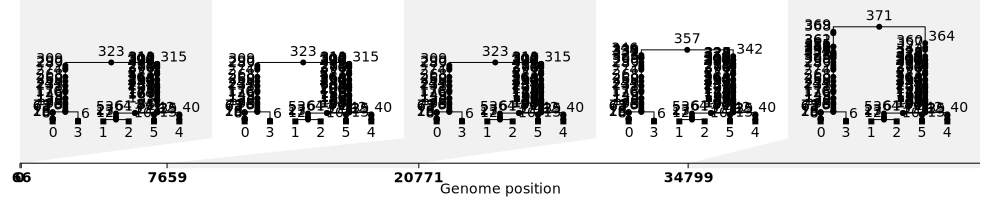

In [7]:
SVG(uts.draw_svg(x_lim=[0, 5e4]))

Note that `keep_unary_if_coalescence` is not a parameter anymore. 

There is now `keep_unary` which outputs the same tree sequence as the original (not helpful).

There is also `keep_unary_in_individuals` which has the same number of edges as simplified.

In [9]:
print("Number of edges:")
print(f'   original: {ts.num_edges}')
print(f" simplified: {sts.num_edges}")
print(f" simplified, keep unary, {uts.num_edges}")
print(f" extend edges: {eets.num_edges}")
print(f" extend paths: {epts.num_edges}")

Number of edges:
   original: 848
 simplified: 206
 simplified, keep unary, 848
 extend edges: 163
 extend paths: 148


### Now lets increase the genome length to $10^7$
We will decrease number of replicates to save time.

In [21]:
res = []
for ts in tqdm(msprime.sim_ancestry(1000, population_size=1000, sequence_length=1e7, recombination_rate=1e-8, random_seed=40,
                          record_full_arg=True, num_replicates=50)):
    sts = ts.simplify()
    #new_sts = ts.simplify(keep_unary_if_coalescent=True)
    eets = sts.extend_edges()
    epts = sts.extend_paths()
    res.append((sts.num_edges, eets.num_edges, epts.num_edges))

22it [04:52, 18.50s/it]IOStream.flush timed out
50it [12:29, 14.99s/it]


In [ ]:
res = np.array(res)
x = np.argsort(np.argsort(res[:, 0]))
f = go.Figure(data=[go.Scatter(x=x,y=res[:,0], name='Simplified',mode='markers'),
                    go.Scatter(x=x,y=res[:,1], name='Extended Edges', mode='markers'),
                    go.Scatter(x=x,y=res[:,2], name='Extended Paths', mode='markers')]
             )
f.update_layout(title='Edges for tree sequence of length 1e7 with 1000 samples', xaxis_title='Sample Replicates',
                yaxis_title='Number of Edges')
f.show()

plotly.io.write_image(f, "paper/newplots/simp_vs_ext_1000s_50reps_1e7.pdf", format='pdf')
# fig, ax = plt.subplots(figsize=(10,7))

# ax.scatter(x, res[:, 0], label='simplified')
# ax.scatter(x, res[:, 1], label='extended')
# ax.set_xlabel('Sample Replicate')
# ax.set_ylabel("Number of Edges")
# ax.set_title('')
# ax.legend();
# plt.savefig('paper/simplified_vs_extended_1000sample_50reps_SL1e7.png')

In [23]:
props = np.asarray([1-(res[i,1]/res[i,0]) for i in range(res.shape[0])])
print('For sequence length 10^7, the edge_extend method reduces the number of edges of a simplified tree sequence by', np.average(props), 'on average.')

For sequence length 10^7, the edge_extend method reduces the number of edges of a simplified tree sequence by 0.32060177717284527 on average.


### Compare ratio of edges to sequence length between simplified and extended tree sequences.

In [3]:
from plotly.subplots import make_subplots
from tqdm import tqdm

In [79]:
res = {}
trees = {}
for num_samples in [10, 100, 1000]:
    res[num_samples] = {}
    trees[num_samples] = {}
    for L in tqdm([1e6, 5e6, 1e7, 5e7]):
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, coalescing_segments_only=False)
        sts = ts.simplify()
        eets = sts.extend_edges()
        epts = sts.extend_paths()
        trees[num_samples][L] = ts.num_trees
        res[num_samples][L] = (sts.num_edges, eets.num_edges, epts.num_edges)

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [05:44<00:00, 86.17s/it]


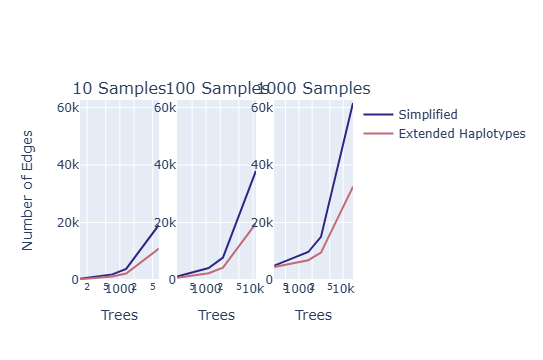

In [81]:
f = make_subplots(rows=1, cols=3, subplot_titles=('10 Samples', '100 Samples', '1000 Samples'))
maxval = 0
for a in res.values():
    for b in a.values():
        maxval = max(maxval, max(b))
for c, num_samples in zip([1,2,3],res):
    Lvals = list(res[num_samples].keys())
    treelist = list(trees[num_samples].values())
    Lvals.sort()
    sim = [res[num_samples][L][0] for L in Lvals]
    # ee = [res[num_samples][L][1] for L in Lvals]
    ep = [res[num_samples][L][2] for L in Lvals]
    if c == 1:
        f.add_trace(
            go.Scatter(x=treelist, y=sim, name='Simplified', mode = 'lines', marker=dict(color=colors['blue'])),
        row = 1, col = c)
        # f.add_trace(go.Scatter(x=Lvals, y=ee, name='Extended Edges', mode='lines', marker=dict(color='red')),
        #             row =1, col=c
        #            )
        f.add_trace(go.Scatter(x=treelist, y=ep, name='Extended Haplotypes', mode='lines', marker=dict(color=colors['red'])
                              ), row=1,col=c
                   )
        f.update_yaxes(title_text='Number of Edges', range = [0,maxval+1000], row=1, col=c)
    if c != 1:
        f.add_trace(
            go.Scatter(x=treelist, y=sim, name='Simplified', mode = 'lines', marker=dict(color=colors['blue']), showlegend=False),
        row = 1, col = c)
        # f.add_trace(go.Scatter(x=Lvals, y =ee, name='Extended Edges', mode='lines', marker=dict(color='red'), showlegend=False),
        #             row =1, col=c
        #            )
        f.add_trace(go.Scatter(x=treelist, y=ep, name='Extended Haplotypes', mode='lines', marker=dict(color=colors['red']), showlegend=False),
                              row=1,col=c
                   )
        f.update_yaxes(title_text='', range = [0,maxval+1000], row=1, col = c)
    f.update_xaxes(title_text='Trees', type='log', row = 1, col= c)
f.show()
plotly.io.write_image(f, 'paper/newplots_wo_ee/num_trees_vs_Num_edges_subplot.pdf',format='pdf')

## Visualize the Proportions of Edges reduced between simplified and extended sequences.

In [17]:
props = {}
for num_samples in res:
    props[num_samples] = {}
    for L in res[num_samples].keys():
        props[num_samples][L] = {}
        props[num_samples][L]['ee'] = (1-(res[num_samples][L][1]/res[num_samples][L][0]))
        props[num_samples][L]['ep'] = (1-(res[num_samples][L][2]/res[num_samples][L][0]))

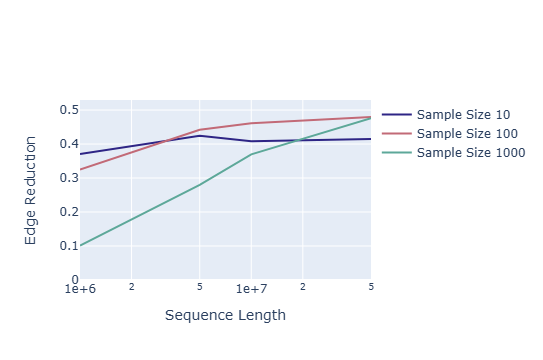

In [20]:
f = go.Figure()
maxval = 0
for a in props.values():
    for b in a.values():
        for c in b.values():
            maxval = max(maxval, c)
for ax, num_samples, c in zip([1,2,3], props, colors):
    treelist = list(trees[num_samples].values())
    Lvals = list(props[num_samples].keys())
    Lvals.sort()
    sim_ee = [props[num_samples][L]['ee'] for L in Lvals]
    sim_ep = [props[num_samples][L]['ep'] for L in Lvals]
    # f.add_trace(go.Scatter(x=Lvals, y = sim_ee, name = f'Extend Edges Sample Size {num_samples}', mode = 'lines', legendgroup = 'Extend Edges', legendgrouptitle=dict(text='Extend Edges')))
    f.add_trace(go.Scatter(x=Lvals, y = sim_ep, name = f'Sample Size {num_samples}', mode = 'lines', marker=dict(color=colors[c])))
f.update_xaxes(type='log', exponentformat='e', title='Sequence Length')
f.update_yaxes(title='Edge Reduction', range = [0, maxval+0.05])
# f.update_layout(title='Edge reduction in tree sequences produced from Extension Methods')
f.show()

# plotly.io.write_image(f, 'paper/newplots_wo_ee/edge_reduction_prop_vs_numtrees.pdf', format='pdf')

### Edge Inference
We know look at proportion of edges which were correctly inserted into neighboring trees with `edge_extend`.

In [3]:
def get_span_stats(ts, ets):
    time_map = {}
    for n in ts.nodes():
        time_map[n.time] = n.id
    total_added_span = 0
    wrongly_added_span = 0
    for interval, t, et in ts.coiterate(ets):
        interval_length = interval[1] - interval[0]
        t_nodes = list(t.nodes())
        for n in et.nodes():
            if et.num_children(n) == 1:
                total_added_span += interval_length
            on = time_map[et.time(n)]
            if on not in t_nodes:
                assert et.num_children(n) == 1
                wrongly_added_span += interval_length
    return total_added_span, wrongly_added_span

In [ ]:
total_added_span, wrongly_added_span = get_span_stats(sts, epts)
print(f"Out of a total of {total_added_span} added edge span, "
      f"we have wrongly added {wrongly_added_span} span, "
      f"a proportion of {wrongly_added_span / total_added_span}.")

# What's the sampling distribution?

In [76]:
reps = msprime.sim_ancestry(100, population_size=1000, sequence_length=1e7, recombination_rate=1e-8,
                           coalescing_segments_only=False, num_replicates=100)
etotals = []
ewrongs = []
ptotals = []
pwrongs = []
for ts in tqdm(reps):
    sts = ts.simplify()
    # eets = sts.extend_edges()
    epts = sts.extend_paths()
    a, b = get_span_stats(ts, epts)
    # c, d = get_span_stats(ts, eets)
    ptotals.append(a)
    pwrongs.append(b)
    # etotals.append(c)
    # ewrongs.append(d)

100it [14:51,  8.92s/it]


In [77]:
# etotals = np.asarray(etotals)
# ewrongs = np.asarray(ewrongs)
ptotals = np.asarray(ptotals)
pwrongs = np.asarray(pwrongs)
np.save('stats/sampling_dist_ptotals.npy', ptotals)
np.save('stats/sampling_dist_pwrongs.npy', pwrongs)

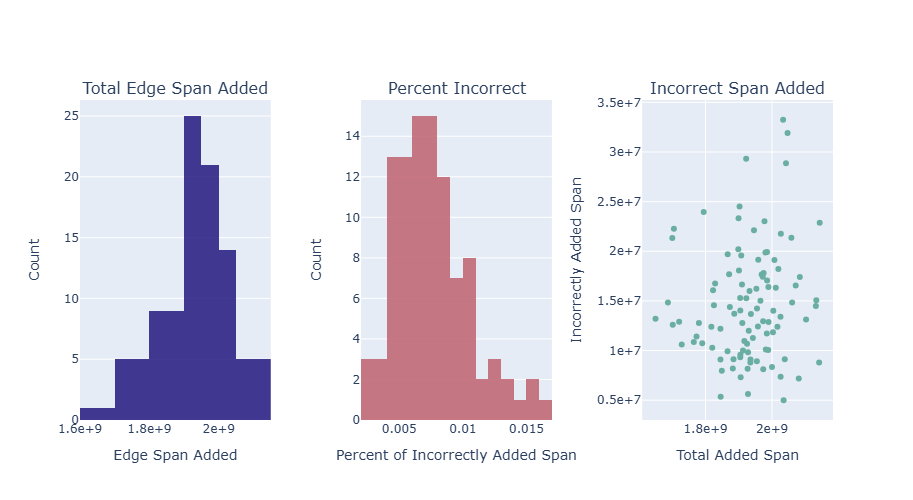

In [20]:
f = make_subplots(rows=1, cols=3,
                  subplot_titles=("Total Edge Span Added", "Percent Incorrect", "Incorrect Span Added"),
                  horizontal_spacing=0.12
                 )
# f.add_trace(go.Histogram(x=etotals, name = 'Extend Edges'), row=1, col=1)
f.add_trace(go.Histogram(x=ptotals, name = 'Extend Paths', marker=dict(color=colors['blue'])), row=1, col=1)
# f.add_trace(go.Histogram(x=(ewrongs/etotals), name = 'Extend Edges'), row=1, col=2)
f.add_trace(go.Histogram(x=(pwrongs/ptotals), name='Extend Paths', marker=dict(color=colors['red'])), row=1,col=2)
# f.add_trace(go.Scatter(x=etotals, y=ewrongs, mode = 'markers', name='Extend Edges'), row=1, col=3)
f.add_trace(go.Scatter(x=ptotals, y =pwrongs, mode='markers',name='Extend Paths', marker=dict(color=colors['lgreen'])), row=1,col=3)
f.update_xaxes(title= 'Edge Span Added', exponentformat='e', row=1,col=1)
f.update_xaxes(title= 'Percent of Incorrectly Added Span', row=1, col=2)
f.update_xaxes(title= 'Total Added Span', exponentformat='e', row=1, col=3)
f.update_yaxes(title= 'Count', row=1, col=1)
f.update_yaxes(title="Count", row=1, col=2)
f.update_yaxes(title="Incorrectly Added Span", exponentformat='e', row=1, col=3, title_standoff = 7)
f.update_layout(showlegend=False, barmode='overlay', width=1000,height=500)
f.update_traces(opacity=0.9)
f.show()

plotly.io.write_image(f, 'paper/newplots_wo_ee/sampling_dist_recomb.pdf', format = 'pdf')

# Other ideas

- Make a plot with x-axis along the genome and y-axis time
with a line for each added edge
and color whether it was right or not.

# What's about gene conversion events?

Here's the same thing, but with gene conversion instead of recombination:

In [21]:
reps = msprime.sim_ancestry(100, population_size=1000, sequence_length=1e7, 
                            gene_conversion_rate=1e-8, gene_conversion_tract_length=1000,
                            record_full_arg=True, num_replicates=100)
etotals = []
ewrongs = []
ptotals = []
pwrongs = []
for ts in tqdm(reps):
    sts = ts.simplify()
    # eets = sts.extend_edges()
    epts = sts.extend_paths()
    a, b = get_span_stats(ts, epts)
    # c, d = get_span_stats(ts, eets)
    ptotals.append(a)
    pwrongs.append(b)
    # etotals.append(c)
    # ewrongs.append(d)
# etotals = np.asarray(etotals)
# ewrongs = np.asarray(ewrongs)
ptotals = np.asarray(ptotals)
pwrongs = np.asarray(pwrongs)

100it [1:41:14, 60.74s/it]


In [75]:
np.save('stats/gene_conversion_ptotals.npy', ptotals)
np.save('stats/gene_conversion_pwrongs.npy', pwrongs)

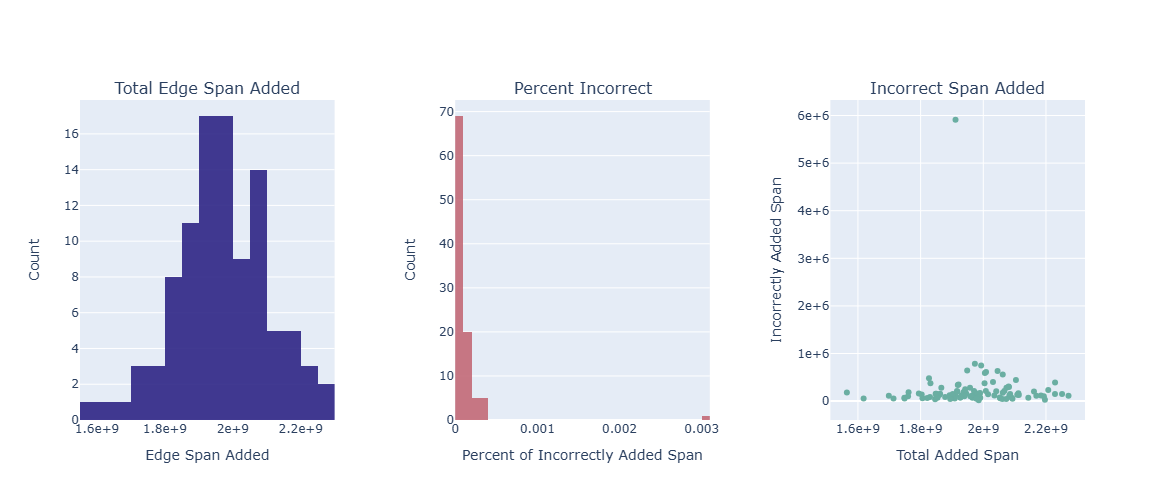

In [22]:
f = make_subplots(rows=1, cols=3,
                  subplot_titles=("Total Edge Span Added", "Percent Incorrect", "Incorrect Span Added"),
                  horizontal_spacing=0.12
                 )
# f.add_trace(go.Histogram(x=etotals, name = 'Extend Edges'), row=1, col=1)
f.add_trace(go.Histogram(x=ptotals, name = 'Extend Paths', marker=dict(color=colors['blue'])), row=1, col=1)
# f.add_trace(go.Histogram(x=(ewrongs/etotals), name = 'Extend Edges'), row=1, col=2)
f.add_trace(go.Histogram(x=(pwrongs/ptotals), name='Extend Paths', marker=dict(color=colors['red'])), row=1,col=2)
# f.add_trace(go.Scatter(x=etotals, y=ewrongs, mode = 'markers', name='Extend Edges'), row=1, col=3)
f.add_trace(go.Scatter(x=ptotals, y =pwrongs, mode='markers',name='Extend Paths', marker=dict(color=colors['lgreen'])), row=1,col=3)
f.update_xaxes(title= 'Edge Span Added', exponentformat='e', row=1,col=1)
f.update_xaxes(title= 'Percent of Incorrectly Added Span', row=1, col=2)
f.update_xaxes(title= 'Total Added Span', exponentformat='e', row=1, col=3)
f.update_yaxes(title= 'Count', row=1, col=1)
f.update_yaxes(title="Count", row=1, col=2)
f.update_yaxes(title="Incorrectly Added Span", exponentformat='e', row=1, col=3, title_standoff = 7)
f.update_layout(showlegend=False, barmode='overlay', width=1000, height=500)
f.update_traces(opacity=0.9)
f.show()

plotly.io.write_image(f, 'paper/newplots_wo_ee/sampling_dist_geneconversion.pdf', format = 'pdf')

# Computing Statsitcs
We also want to look at computation time on simplified and extended tree sequences when computing statistics like TajimasD.

In [21]:
samples = [100,1000]
lengths = [1e6, 5e6, 1e7, 5e7, 1e8]
num_trees = np.zeros((len(samples), len(lengths)))
stimes = np.zeros((len(samples),len(lengths)))
etimes = np.zeros((len(samples),len(lengths)))
ptimes = np.zeros((len(samples),len(lengths)))
for i,s in enumerate(samples):
    for j,l in enumerate(lengths):
        ts = msprime.sim_ancestry(s,population_size=1000, sequence_length=l, recombination_rate=1e-8, record_full_arg=True)
        print(ts.num_trees)
        # USE MICROBENCHMARK
        sts = ts.simplify()
        num_trees[i,j] = sts.num_trees
        start = time.time()
        sts.Tajimas_D()
        end = time.time()
        stimes[i,j] = end-start
        #print('SIMPLIFIED', s, l, '\n Time:', end-start)
        
        # ets = sts.extend_edges()
        # start = time.time()
        # ets.Tajimas_D()
        # end = time.time()
        # etimes[i,j] = end-start

        epts = sts.extend_paths()
        start = time.time()
        epts.Tajimas_D()
        end = time.time()
        ptimes[i,j] = end-start
        #print('EXTENDED', s, l, '\n Time:', end-start)

188
1236
2315
11396
23549
344
1668
3451
16450
32470


In [22]:
stimes[0,:], ptimes, maxval, num_trees

(array([0.01486921, 0.00082207, 0.00075483, 0.00236011, 0.00955868]),
 array([[0.00106192, 0.00095081, 0.00132942, 0.00276303, 0.0066545 ],
        [0.0004859 , 0.00091529, 0.00179625, 0.02363777, 0.08482337]]),
 0.4796150856407645,
 array([[  188.,  1236.,  2315., 11396., 23549.],
        [  344.,  1668.,  3451., 16450., 32470.]]))

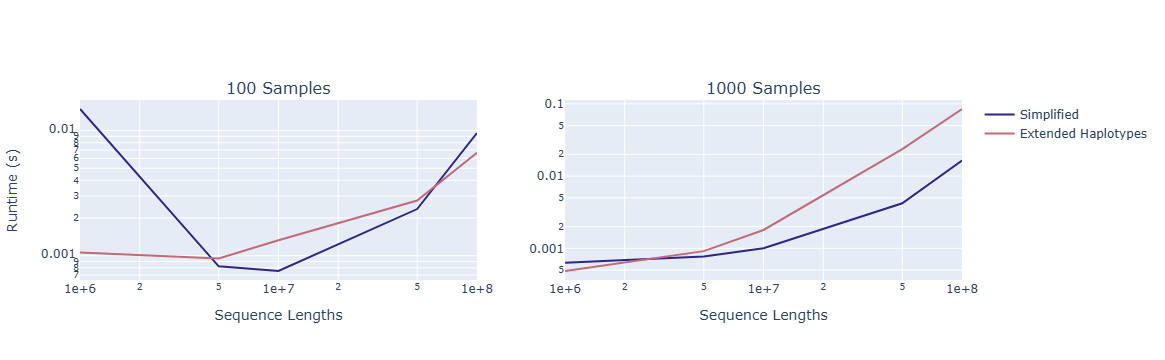

In [28]:
f = make_subplots(rows=1, cols=2, subplot_titles=('100 Samples', '1000 Samples'))
maxval = np.max([np.max(ptimes), np.max(stimes)])
for c, num_samples in zip([1,2],[100,1000]):
    if c == 1:
        f.add_trace(
            go.Scatter(x=lengths, y=stimes[c-1,:], name='Simplified', mode = 'lines', marker=dict(color=colors['blue'])),
        row = 1, col = c)
        f.add_trace(go.Scatter(x=lengths, y=ptimes[c-1,:], name='Extended Haplotypes', mode='lines', marker=dict(color=colors['red'])
                              ), row=1,col=c
                   )
        f.update_yaxes(type='log',title_text='Runtime (s)', row=1, col=c)
    if c != 1:
        f.add_trace(
            go.Scatter(x=lengths, y=stimes[c-1,:], name='Simplified', mode = 'lines', marker=dict(color=colors['blue']), showlegend=False),
        row = 1, col = c)
        # f.add_trace(go.Scatter(x=Lvals, y =ee, name='Extended Edges', mode='lines', marker=dict(color='red'), showlegend=False),
        #             row =1, col=c
        #            )
        f.add_trace(go.Scatter(x=lengths, y=ptimes[c-1,:], name='Extended Haplotypes', mode='lines', marker=dict(color=colors['red']), showlegend=False),
                              row=1,col=c
                   )
        f.update_yaxes(type='log', title_text='', row=1, col = c)
    f.update_xaxes(title_text='Sequence Lengths',type = 'log', row = 1, col= c, exponentformat='e')
f.show()
plotly.io.write_image(f, 'paper/newplots_wo_ee/simp_vs_ext_tajimasD_runtime_SL.pdf',format='pdf')

# Discrepancy Function

For a tree sequence $T$ and a node $x$ and position $i$, let $D_T(x, i)$ be the set of descendant
samples of $x$ in $T$ at position $i$, and for node $x$ in $T_1$ and node $y$ in $T_2$, where both $T_j$
are tree sequences of length $L$, let
$$
   \rho_{T_1, T_2}(x, y)
   =
   \frac{1}{L} \sum_i \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right],
$$
where the thing in the $[ ]$'s means that it should be 1 if True, 0 if False.
This is the fraction of the sequence along which $x$ and $y$ have exactly the same descendant set
(and so is a similiarity).
Then, let
$$
  \widehat{d}(x, T_1, T_2) = \min_y \left\{ |t_x-t_y|(1 - \rho_{T_1, T_2}(x, y)) \right\} ,
$$
which is the proportion of the genome over which the descendant set of $x$ *does not* match
that of $y$, where $y$ is it's (global) best matching node. This proportion is weighted by the difference of the branch lengths $|t_x-t_y|$, where $t_x$ and $t_y$ denote the time of occurance for nodes $x$ and $y$, respectively. 

Note that this is *different* than
$$
   \frac{1}{L} \sum_i \min_y \left(1 - \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right]\right),
$$
which would tell us the proportion of the genome over which $x$ does not have a perfectly matching node,
i.e., a node which has exactly the same descendant set.

We are doing this because want to find the node $y$ that is the best match over the whole genome,
since this tells us how well nodes are identified across trees.

We then define the *discrepancy* between $T_1$ and $T_2$ to be 
$$
\widehat{d}(T_1,T_2) = \sum_{x\in T_1} \widehat{d}(x, T_1, T_2) .
$$

Note that the algorithm to compute this
is $n_1 t$, rather than $n_1 n_2 t$ as we had above,
because on each tree, for each node $x$,
we need only look at $O(1)$ nodes rather than all nodes.

### Test Discrepancy function

In [4]:
from COPYevaluation import tree_discrepancy

In [26]:
samples = [100,1000]
lengthlist = [1e5, 5e5, 1e6, 5e6, 1e7, 5e7, 1e8]
# ee_dis = np.zeros((3, len(samples),len(lengthlist)))
# ep_dis = np.zeros((3, len(samples),len(lengthlist)))
sts_dis = np.zeros((3,len(samples),len(lengthlist)))
for i, num_samples in enumerate(samples):
    for j, L in enumerate(lengthlist):
        print(num_samples, L)
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, coalescing_segments_only=False)
        sts = ts.simplify()
        a, b, c = tree_discrepancy(sts, ts)
        sts_dis[0,i,j] = a
        sts_dis[1,i,j] = b
        sts_dis[2,i,j] = c
        # eets= sts.extend_edges()
        # epts = sts.extend_paths()
        # d, r, t = tree_discrepancy(eets, ts)
        # ee_dis[0,i,j] = d
        # ee_dis[1,i,j] = r
        # ee_dis[2,i,j] = t
        # e, s, u = tree_discrepancy(epts, ts)
        # ep_dis[0,i,j] = e
        # ep_dis[1,i,j] = s
        # ep_dis[2,i,j] = u
        

100 100000.0
100 500000.0
100 1000000.0
100 5000000.0
100 10000000.0
100 50000000.0
100 100000000.0
1000 100000.0
1000 500000.0
1000 1000000.0
1000 5000000.0
1000 10000000.0
1000 50000000.0
1000 100000000.0


In [28]:
np.save('Simplifed_discrepancy.npy', sts_dis)

In [77]:
ee_dis = np.load('Extend_edges_discrepancy.npy')
ep_dis = np.load('Extend_paths_discrepancy.npy')

In [ ]:
layout=dict(title='Discrepancy between Extended Sequences vs Ground Truth')
fig = go.Figure()
for i,s in enumerate(samples):
    # fig.add_trace(go.Scatter(x=lengthlist, y = ee_dis[0,i], marker=dict(color='teal'),name=f'{s} samples', legendgroup='Extend Edges', legendgrouptitle=dict(text='Extend Edges')))
    fig.add_trace(go.Scatter(x=lengthlist, y = ep_dis[0,i], marker=dict(color='purple'), name=f'{s} samples', legendgroup='Extend Paths', legendgrouptitle=dict(text='Extend Paths')))
    fig.add_trace(go.Scatter(x=lengthlist, y = sts_dis[0,i],marker=dict(color='orchid'), name=f'{s} samples', legendgroup='Simplified TS', legendgrouptitle=dict(text='Simplified TS')))
fig.update_xaxes(type='log')
# plotly.io.write_image(fig, 'paper/newplots/discrepancy_ee_vs_ep.pdf', format='pdf')
fig.show()

In [ ]:
fig = go.Figure(layout=dict(title='RMSE between Extended Sequences vs Ground Truth'))
for i,s in enumerate(samples):
    fig.add_trace(go.Scatter(x=lengthlist, y = ee_dis[1,i], marker=dict(color='teal'),name=f'{s} samples', legendgroup='Extend Edges', legendgrouptitle=dict(text='Extend Edges')))
    fig.add_trace(go.Scatter(x=lengthlist, y = ep_dis[1,i], marker=dict(color='purple'), name=f'{s} samples', legendgroup='Extend Paths', legendgrouptitle=dict(text='Extend Paths')))
    fig.add_trace(go.Scatter(x=lengthlist, y = sts_dis[1,i], marker=dict(color='orchid'),name=f'{s} samples',legendgroup='Simplified TS', legendgrouptitle=dict(text='Simplifed TS')))
fig.update_xaxes(type='log')
plotly.io.write_image(f, 'paper/newplots/rmse_ee_vs_ep.pdf', format='pdf')
fig.show()

In [ ]:
fig = go.Figure(layout=dict(title='True Proportion between Extended Sequences vs Ground Truth'))
for i,s in enumerate(samples):
    fig.add_trace(go.Scatter(x=lengthlist, y = ee_dis[2,i], marker=dict(color='teal'),name=f'{s} samples', legendgroup='Extend Edges', legendgrouptitle=dict(text='Extend Edges')))
    fig.add_trace(go.Scatter(x=lengthlist, y = ep_dis[2,i], marker=dict(color='purple'), name=f'{s} samples', legendgroup='Extend Paths', legendgrouptitle=dict(text='Extend Paths')))
    fig.add_trace(go.Scatter(x=lengthlist, y = sts_dis[2,i], marker=dict(color='orchid'),name=f'{s} samples', legendgroup='Simplifed TS', legendgrouptitle=dict(text='Simplifed TS')))
fig.update_xaxes(type='log')
plotly.io.write_image(f, 'paper/newplots/true_prop_ee_vs_ep.pdf', format='pdf')
fig.show()

# Discrepancy to compare TSInfer and Extend Haplotypes

We will do so in two or three settings and plot results for each.

1. We will scale tree sequences generated with `coalescing_segments_only` over sequence length (max SL = 1e8, fix sample = 500).

2. We will scale tree sequences generated with `coalescing_segments_only` over sample size. (fix length to 5e7)

## 1.

In [4]:
samplelist = [10, 50, 100, 500, 1000]
lengthlist = [1e6, 5e6, 1e7, 5e7, 1e8]

sts_dis = np.zeros((len(samplelist),3))
ets_dis = np.zeros((len(samplelist),3))
inf_sts_dis = np.zeros((len(samplelist),3))
inf_ets_dis = np.zeros((len(samplelist),3))
inf_dis = np.zeros((len(samplelist),3))

' Lets first run the sample experiments '
for i,sample in enumerate(samplelist):
    print(i)
    # ts = msprime.sim_ancestry(sample, population_size=1000, sequence_length=5e7,
    #                               recombination_rate=1e-8, coalescing_segments_only=False)
    ts = tskit.load(f'trees/ts2_{sample}s_5e7')
    # sts = ts.simplify()
    # ets = sts.extend_paths()
    # pre_dis, pre_rmse, pre_true_prop = tree_discrepancy(sts,ts)
    # sts_dis[i] = np.asarray([pre_dis, pre_rmse, pre_true_prop])
    # dis, rmse, true_prop = tree_discrepancy(ets, ts)
    # ets_dis[i] = np.asarray([dis,rmse,true_prop])

    mutation_rate = 1e-7  # mutation rate for the inferred tree sequences
    ts = msprime.sim_mutations(ts, mutation_rate)
    infer_ts = tsinfer.infer(tsinfer.SampleData.from_tree_sequence(ts))
    t = infer_ts.tables
    t.compute_mutation_times()
    infer_ts = t.tree_sequence()
    infer_dis, infer_rmse, infer_true_pop = tree_discrepancy(infer_ts, ts)
    inf_dis[i] = np.asarray([infer_dis, infer_rmse, infer_true_pop])
    # infer_sts = infer_ts.simplify()
    # infer_ets = infer_sts.extend_paths()
    # pre_infer_dis, pre_infer_rmse, pre_infer_true_prop = tree_discrepancy(infer_sts, ts)
    # inf_sts_dis[i] = np.asarray([pre_infer_dis, pre_infer_rmse, pre_infer_true_prop])
    # infer_ets_dis, infer_ets_rmse, infer_ets_true_prop = tree_discrepancy(infer_ets, ts)
    # inf_ets_dis[i] = np.asarray([infer_ets_dis, infer_ets_rmse, infer_ets_true_prop])

0
1
2
3
4


In [6]:
np.save('discrepancy/infer_discrepancy_5e7_csoFalse.npy', inf_dis)
# np.save('discrepancy/simplified_discrepancy_5e7_csoFalse.npy',sts_dis)
# np.save('discrepancy/extend_paths_discrepancy_5e7_csoFalse.npy',ets_dis)
# np.save('discrepancy/infer_simplified_discrepancy_5e7_csoFalse.npy', inf_sts_dis)
# np.save('discrepancy/infer_extend_paths_discrepancy_5e7_csoFalse.npy', inf_ets_dis)

In [76]:
inf_dis = np.load('discrepancy/infer_discrepancy_5e7_csoFalse.npy')
sts_dis = np.load('discrepancy/simplified_discrepancy_5e7_csoFalse.npy')
ets_dis = np.load('discrepancy/extend_paths_discrepancy_5e7_csoFalse.npy')
inf_sts_dis= np.load('discrepancy/infer_simplified_discrepancy_5e7_csoFalse.npy')
inf_ets_dis = np.load('discrepancy/infer_extend_paths_discrepancy_5e7_csoFalse.npy')

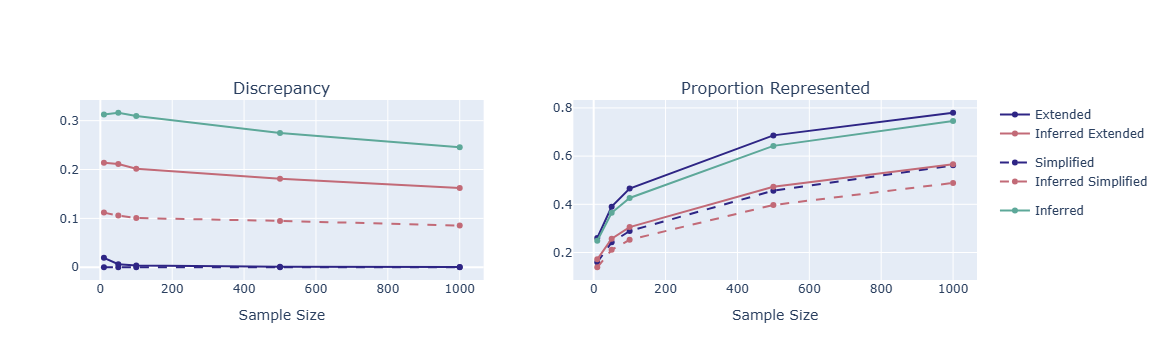

In [78]:
f = make_subplots(rows = 1, cols =2, subplot_titles= ['Discrepancy', 'Proportion Represented'])
f.add_trace(go.Scatter(x = samplelist, y = ets_dis[:,0], legendgroup = 'Extended', name = 'Extended', line = dict(color=colors['blue'])), row = 1, col = 1)
f.add_trace(go.Scatter(x = samplelist, y = sts_dis[:,0], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash')), row = 1, col =1)
f.add_trace(go.Scatter(x = samplelist, y = sts_dis[:,2], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash'), showlegend=False), row=1, col=2)
f.add_trace(go.Scatter(x = samplelist, y = ets_dis[:,2], legendgroup = 'Extended', name = 'Extended', line=dict(color=colors['blue']), showlegend=False), row = 1, col =2)
f.add_trace(go.Scatter(x = samplelist, y = inf_sts_dis[:,0], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color=colors['red'], dash='dash')), row=1, col=1)
f.add_trace(go.Scatter(x = samplelist, y = inf_sts_dis[:,2], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color = colors['red'], dash = 'dash'), showlegend=False), row=1, col=2)
f.add_trace(go.Scatter(x = samplelist, y = inf_ets_dis[:,2], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red'])), row =1 , col =2)
f.add_trace(go.Scatter(x = samplelist, y = inf_ets_dis[:,0], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red']), showlegend=False), row=1, col=1)
f.add_trace(go.Scatter(x = samplelist, y = inf_dis[:,0], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen'])), row=1, col=1)
f.add_trace(go.Scatter(x = samplelist, y = inf_dis[:,2], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen']), showlegend=False), row=1, col=2)
f.update_xaxes(title='Sample Size', row=1)
# f.update_yaxes(type='log', col=1)
f.show()
plotly.io.write_image(f, 'paper/newplots_wo_ee/discrepancy_over_sample_5e7_new.pdf', format='pdf')

## 2.
Fix sample size to 1000 and vary sequence length.

In [6]:
# samplelist = [10, 50, 100, 500, 1000]
lengthlist = [1e6, 5e6, 1e7, 5e7]
names = ['1e6', '5e6', '1e7', '5e7']
sts_dis = np.zeros((len(lengthlist),3))
ets_dis = np.zeros((len(lengthlist),3))
inf_sts_dis = np.zeros((len(lengthlist),3))
inf_ets_dis = np.zeros((len(lengthlist),3))
num_trees = np.zeros(len(lengthlist))
inf_dis = np.zeros((len(lengthlist),3))

'Lets first run the sample experiments'
for i, (length,name) in enumerate(zip(lengthlist, names)):
    # ts = msprime.sim_ancestry(1000, population_size=1000, sequence_length=length,
    #                               recombination_rate=1e-8, coalescing_segments_only=False)
    ts = tskit.load(f'trees/ts_1000s_{name}')
    print(i)
    # sts = ts.simplify()
    # num_trees[i] = sts.num_trees
    # ets = sts.extend_paths()
    # pre_dis, pre_rmse, pre_true_prop = tree_discrepancy(sts,ts)
    # sts_dis[i] = np.asarray([pre_dis, pre_rmse, pre_true_prop])
    # dis, rmse, true_prop = tree_discrepancy(ets, ts)
    # ets_dis[i] = np.asarray([dis,rmse,true_prop])

    mutation_rate = 1e-7  # mutation rate for the inferred tree sequences
    ts = msprime.sim_mutations(ts, mutation_rate)
    infer_ts = tsinfer.infer(tsinfer.SampleData.from_tree_sequence(ts))
    t = infer_ts.tables
    t.compute_mutation_times()
    infer_ts = t.tree_sequence()
    infer_dis, infer_rmse, infer_true_prop = tree_discrepancy(infer_ts, ts)
    inf_dis[i] = np.asarray([infer_dis, infer_rmse, infer_true_prop])
    # infer_sts = infer_ts.simplify()
    # infer_ets = infer_sts.extend_paths()
    # pre_infer_dis, pre_infer_rmse, pre_infer_true_prop = tree_discrepancy(infer_sts, ts)
    # inf_sts_dis[i] = np.asarray([pre_infer_dis, pre_infer_rmse, pre_infer_true_prop])
    # infer_ets_dis, infer_ets_rmse, infer_ets_true_prop = tree_discrepancy(infer_ets, ts)
    # inf_ets_dis[i] = np.asarray([infer_ets_dis, infer_ets_rmse, infer_ets_true_prop])
np.save('discrepancy/infer_discrepancy_1000s_csoFalse.npy', inf_dis)

0
1
2
3


In [ ]:
longlength = [(1e8, '1e8')]
longinfdis = np.zeros((1,3))
for (length, name) in longlength:
    ts = tskit.load(f'trees/ts_1000s_{name}')
    mutation_rate = 1e-7  # mutation rate for the inferred tree sequences
    ts = msprime.sim_mutations(ts, mutation_rate)
    infer_ts = tsinfer.infer(tsinfer.SampleData.from_tree_sequence(ts))
    t = infer_ts.tables
    t.compute_mutation_times()
    infer_ts = t.tree_sequence()
    infer_dis, infer_rmse, infer_true_prop = tree_discrepancy(infer_ts, ts)
    longinfdis[0] = np.asarray([infer_dis, infer_rmse, infer_true_prop])

In [ ]:
np.save('discrepancy/infer_discrepancy_1000s_csoFalse_1e8.npy', longinfdis)

In [ ]:
np.save('discrepancy/infer_discrepancy_1000s_csoFalse.npy', inf_dis)
# np.save('discrepancy/simplified_discrepancy_1000s_csoFalse.npy',sts_dis)
# np.save('discrepancy/extend_paths_discrepancy_1000s_csoFalse.npy',ets_dis)
# np.save('discrepancy/infer_simplified_discrepancy_1000s_csoFalse.npy', inf_sts_dis)
# np.save('discrepancy/infer_extend_paths_discrepancy_1000s_csoFalse.npy', inf_ets_dis)
# np.save('discrepancy/discrepancy_1000s_numtrees.npy', num_trees)

In [73]:
inf_dis = np.load('discrepancy/infer_discrepancy_1000s_csoFalse.npy')
sts_dis = np.load('discrepancy/simplified_discrepancy_1000s_csoFalse.npy')
ets_dis = np.load('discrepancy/extend_paths_discrepancy_1000s_csoFalse.npy')
inf_sts_dis = np.load('discrepancy/infer_simplified_discrepancy_1000s_csoFalse.npy')
inf_ets_dis = np.load('discrepancy/infer_extend_paths_discrepancy_1000s_csoFalse.npy')
num_trees = np.load('discrepancy/discrepancy_1000s_numtrees.npy')

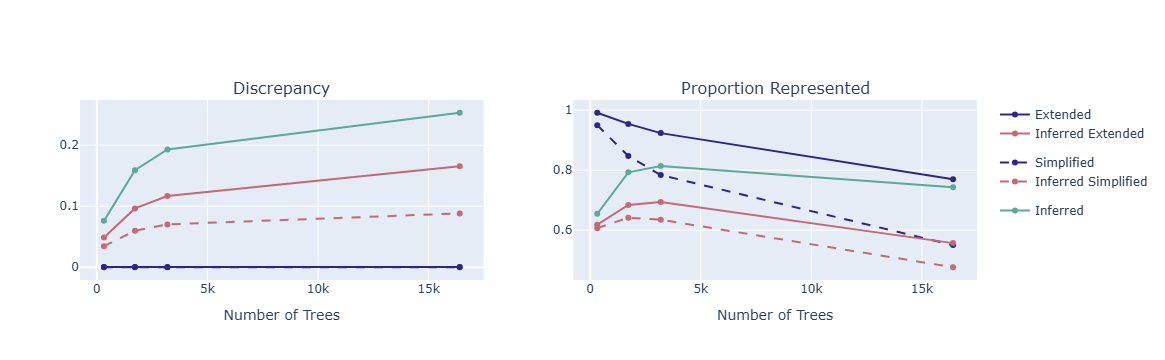

In [75]:
f = make_subplots(rows = 1, cols =2, subplot_titles= ['Discrepancy', 'Proportion Represented'])
f.add_trace(go.Scatter(x = num_trees[:-1], y = ets_dis[:-1,0], legendgroup = 'Extended', name = 'Extended', line = dict(color=colors['blue'])), row = 1, col = 1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = sts_dis[:-1,0], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash')), row = 1, col =1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = sts_dis[:-1,2], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash'), showlegend=False), row=1, col=2)
f.add_trace(go.Scatter(x = num_trees[:-1], y = ets_dis[:-1,2], legendgroup = 'Extended', name = 'Extended', line=dict(color=colors['blue']), showlegend=False), row = 1, col =2)
f.add_trace(go.Scatter(x = num_trees[:-1], y = inf_sts_dis[:-1,0], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color=colors['red'], dash='dash')), row=1, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = inf_sts_dis[:-1,2], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color = colors['red'], dash = 'dash'), showlegend=False), row=1, col=2)
f.add_trace(go.Scatter(x = num_trees[:-1], y = inf_ets_dis[:-1,2], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red'])), row =1 , col =2)
f.add_trace(go.Scatter(x = num_trees[:-1], y = inf_ets_dis[:-1,0], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red']), showlegend=False), row=1, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = inf_dis[:,0], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen'])), row=1, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = inf_dis[:,2], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen']), showlegend=False), row=1, col=2)
f.update_xaxes(title='Number of Trees', row=1)
# f.update_yaxes(type='log', col=1)
f.show()
plotly.io.write_image(f,'paper/newplots_wo_ee/discrepancy_over_seqlen_1000s_new_5e7.pdf', format='pdf')

## 4 Part Dissimilarity Subplot.

In [27]:
tinf_dis = np.load('discrepancy/infer_discrepancy_1000s_csoFalse.npy')
tsts_dis = np.load('discrepancy/simplified_discrepancy_1000s_csoFalse.npy')
tets_dis = np.load('discrepancy/extend_paths_discrepancy_1000s_csoFalse.npy')
tinf_sts_dis = np.load('discrepancy/infer_simplified_discrepancy_1000s_csoFalse.npy')
tinf_ets_dis = np.load('discrepancy/infer_extend_paths_discrepancy_1000s_csoFalse.npy')
num_trees = np.load('discrepancy/discrepancy_1000s_numtrees.npy')

samplelist = [10, 50, 100, 500, 1000]
inf_dis = np.load('discrepancy/infer_discrepancy_5e7_csoFalse.npy')
sts_dis = np.load('discrepancy/simplified_discrepancy_5e7_csoFalse.npy')
ets_dis = np.load('discrepancy/extend_paths_discrepancy_5e7_csoFalse.npy')
inf_sts_dis= np.load('discrepancy/infer_simplified_discrepancy_5e7_csoFalse.npy')
inf_ets_dis = np.load('discrepancy/infer_extend_paths_discrepancy_5e7_csoFalse.npy')

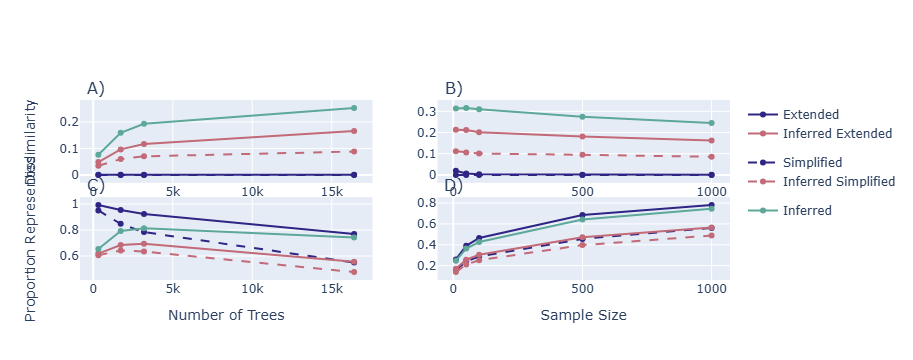

In [74]:
f = make_subplots(rows = 2, cols =2, vertical_spacing=0.08, subplot_titles=['A)','B)','C)','D)'])
f.add_trace(go.Scatter(x = num_trees[:-1], y = tets_dis[:-1,0], legendgroup = 'Extended', name = 'Extended', line = dict(color=colors['blue'])), row = 1, col = 1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tsts_dis[:-1,0], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash')), row = 1, col =1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tsts_dis[:-1,2], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash'), showlegend=False), row=2, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tets_dis[:-1,2], legendgroup = 'Extended', name = 'Extended', line=dict(color=colors['blue']), showlegend=False), row = 2, col =1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tinf_sts_dis[:-1,0], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color=colors['red'], dash='dash')), row=1, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tinf_sts_dis[:-1,2], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color = colors['red'], dash = 'dash'), showlegend=False), row=2, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tinf_ets_dis[:-1,2], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red'])), row =2 , col =1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tinf_ets_dis[:-1,0], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red']), showlegend=False), row=1, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tinf_dis[:,0], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen'])), row=1, col=1)
f.add_trace(go.Scatter(x = num_trees[:-1], y = tinf_dis[:,2], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen']), showlegend=False), row=2, col=1)
f.update_xaxes(title='Number of Trees', row=2,col=1)

f.add_trace(go.Scatter(x = samplelist, y = ets_dis[:,0], legendgroup = 'Extended', name = 'Extended', line = dict(color=colors['blue']),showlegend=False), row = 1, col = 2)
f.add_trace(go.Scatter(x = samplelist, y = sts_dis[:,0], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash'),showlegend=False), row = 1, col =2)
f.add_trace(go.Scatter(x = samplelist, y = sts_dis[:,2], legendgroup = 'Simplified', name = 'Simplified', line = dict(color = colors['blue'], dash = 'dash'), showlegend=False), row=2, col=2)
f.add_trace(go.Scatter(x = samplelist, y = ets_dis[:,2], legendgroup = 'Extended', name = 'Extended', line=dict(color=colors['blue']), showlegend=False), row = 2, col =2)
f.add_trace(go.Scatter(x = samplelist, y = inf_sts_dis[:,0], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color=colors['red'], dash='dash'),showlegend=False), row=1, col=2)
f.add_trace(go.Scatter(x = samplelist, y = inf_sts_dis[:,2], legendgroup = 'Simplified', name = 'Inferred Simplified', line = dict(color = colors['red'], dash = 'dash'), showlegend=False), row=2, col=2)
f.add_trace(go.Scatter(x = samplelist, y = inf_ets_dis[:,2], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red']),showlegend=False), row =2 , col =2)
f.add_trace(go.Scatter(x = samplelist, y = inf_ets_dis[:,0], legendgroup = 'Extended', name = 'Inferred Extended', marker=dict(color=colors['red']), showlegend=False), row=1, col=2)
f.add_trace(go.Scatter(x = samplelist, y = inf_dis[:,0], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen']),showlegend=False), row=1, col=2)
f.add_trace(go.Scatter(x = samplelist, y = inf_dis[:,2], legendgroup = 'inf', name = 'Inferred', marker=dict(color=colors['lgreen']), showlegend=False), row=2, col=2)
f.update_xaxes(title='Sample Size', row=2, col=2)
f.update_yaxes(title='Dissimilarity', row=1, col=1)
f.update_yaxes(title='Proportion Represented', row=2,col=1)

# f.update_layout(width=1000, height=800)
f.layout.annotations[0].update(x=0.025)
f.layout.annotations[2].update(x=0.025)
f.layout.annotations[1].update(x=0.575)
f.layout.annotations[3].update(x=0.575)
f.show()
plotly.io.write_image(f,'paper/newplots_wo_ee/dissimilarity.pdf', format='pdf', width=(6.5-0.75)*300, height=(5.2-0.75)*300)

# Edgewise Tally for Unary Spans.

In [33]:
import matplotlib.pyplot as plt
from itertools import groupby

In [34]:
def edgewise_tally_unary_spans(ts):
    """
    Tally spans for each node into three classes, corresponding to the columns of the output:
        0. Region is not part of a contiguous span in which it is coalescent somewhere.
        1. Region is part of a contiguous span in which it is coalescent somewhere,
            and is unary.
        2. Region is coalescent.
    """
    out = np.zeros((ts.num_nodes, 3))
    p = ts.edge(0).parent
    pi = 0
    for e in ts.edges():
        if e.parent != p or e.id + 1 == ts.num_edges:
            # done with parent p
            pj = e.id + (e.id + 1 == ts.num_edges)
            lefts = ts.edges_left[pi:pj]
            rights = ts.edges_right[pi:pj]
            breaks = np.sort(np.unique(np.concatenate([[0], lefts, rights])))
            overlaps = np.zeros(len(breaks))
            for j, x in enumerate(breaks):
                overlaps[j] = np.sum(lefts <= x) - np.sum(rights <= x)
            not_isolated = np.full(len(breaks) - 1, False)
            coalescent_region = False
            for j in range(0, len(breaks) - 1, 1):
                if overlaps[j] == 0:
                    coalescent_region = False
                else:
                    if overlaps[j] == 1:
                        not_isolated[j] = coalescent_region
                    else:
                        coalescent_region = True
            coalescent_region = False
            for j in range(len(breaks) - 2, -1, -1):
                if overlaps[j] == 0:
                    coalescent_region = False
                else:
                    if overlaps[j] == 1:
                        not_isolated[j] = not_isolated[j] or coalescent_region
                    else:
                        coalescent_region = True
            for j in range(0, len(breaks) - 1, 1):
                if overlaps[j] > 1:
                    out[p, 2] += breaks[j + 1] - breaks[j]
                elif overlaps[j] == 1:
                    if not_isolated[j]:
                        out[p, 1] += breaks[j + 1] - breaks[j]
                    else:
                        out[p, 0] += breaks[j + 1] - breaks[j]
            # on to the next p
            p = e.parent
            pi = e.id
    return out

In [5]:
ts = msprime.sim_ancestry(100, sequence_length=5e6, recombination_rate=1e-8, population_size=1e4, coalescing_segments_only=False, random_seed=1)
ets = ts.simplify().extend_paths()
eets = ts.simplify().extend_edges()

unary_spans = []
for x in [ts, ets, eets]:
    out = edgewise_tally_unary_spans(x)
    sums = out.sum(axis=0)
    total = np.sum(sums[:2])
    props = 100 * np.round(sums / total, 2)
    print(f"Total unary span bordering coalescing: {sums[1]} ({props[1]}%)")
    print(f"Total trapped unary span: {sums[0]} ({props[0]}%)")
    print(f"Total coalescing span: {sums[2]}")
    unary_spans.append(out)


out0, out1, out2 = unary_spans
order = np.argsort(out0[:, 1])

Total unary span bordering coalescing: 2584620259.0 (52.0%)
Total trapped unary span: 2341460645.0 (48.0%)
Total coalescing span: 995000000.0
Total unary span bordering coalescing: 1273839899.0 (100.0%)
Total trapped unary span: 0.0 (0.0%)
Total coalescing span: 995000000.0
Total unary span bordering coalescing: 695017220.0 (100.0%)
Total trapped unary span: 0.0 (0.0%)
Total coalescing span: 995000000.0


Simulate a TS with the following parameters:
` msprime.sim_ancestry(100, sequence_length=5e6, recombination_rate=1e-8, population_size=1e4, coalescing_segments_only=False, random_seed=1)`

From the above output we see that ratio of unary span bordering coalescing between 

- ExtendPaths/Truth = 0.4928
- ExtendEdges/Truth = 0.2689

The trapped unary span of our ground truth is 48% of the TS.

In [ ]:
ts = msprime.sim_ancestry(1000, sequence_length=5e7, recombination_rate=1e-8, population_size=1e4, coalescing_segments_only=False, random_seed=1)
ets = ts.simplify().extend_paths()
eets = ts.simplify().extend_edges()

unary_spans = []
for x in [ts, ets, eets]:
    out = edgewise_tally_unary_spans(x)
    sums = out.sum(axis=0)
    total = np.sum(sums[:2])
    props = 100 * np.round(sums / total, 2)
    print(f"Total unary span bordering coalescing: {sums[1]} ({props[1]}%)")
    print(f"Total trapped unary span: {sums[0]} ({props[0]}%)")
    print(f"Total coalescing span: {sums[2]}")
    unary_spans.append(out)


out0, out1, out2 = unary_spans
order = np.argsort(out0[:, 1])

Simulate a TS with the following parameters:
` msprime.sim_ancestry(1000, sequence_length=5e7, recombination_rate=1e-8, population_size=1e4, coalescing_segments_only=False, random_seed=1)`

From the above output we see that ratio of unary span bordering coalescing between 

- ExtendPaths/Truth = 0.4917
- ExtendEdges/Truth = 0.27828

The trapped unary span of our ground truth is 49% of the TS.

/tmp/ipykernel_31580/2143813866.py:2: RuntimeWarning:

divide by zero encountered in log10

/tmp/ipykernel_31580/2143813866.py:4: RuntimeWarning:

divide by zero encountered in log10



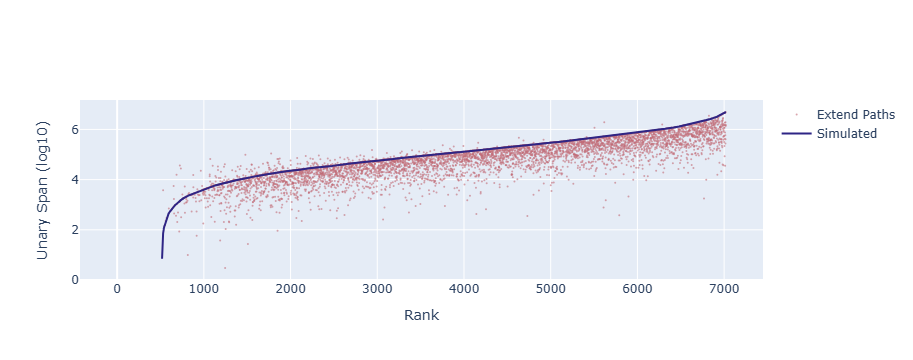

In [9]:
f = go.Figure()
f.add_trace(go.Scatter(x=np.arange(order.size), y=np.log10(out1[order, 1]), name='Extend Paths', mode='markers', marker=dict(color=colors['red'],opacity=0.6, size=2))
           )
f.add_trace(go.Scatter(x=np.arange(order.size), y=np.log10(out0[order, 1]), name="Simulated", mode='lines', marker=dict(color=colors['blue'])))
f.update_xaxes(title='Rank')
f.update_yaxes(title='Unary Span (log10)')
f.show()
plotly.io.write_image(f, 'paper/newplots_wo_ee/better_unary_spans_ep_log.pdf', format='pdf')

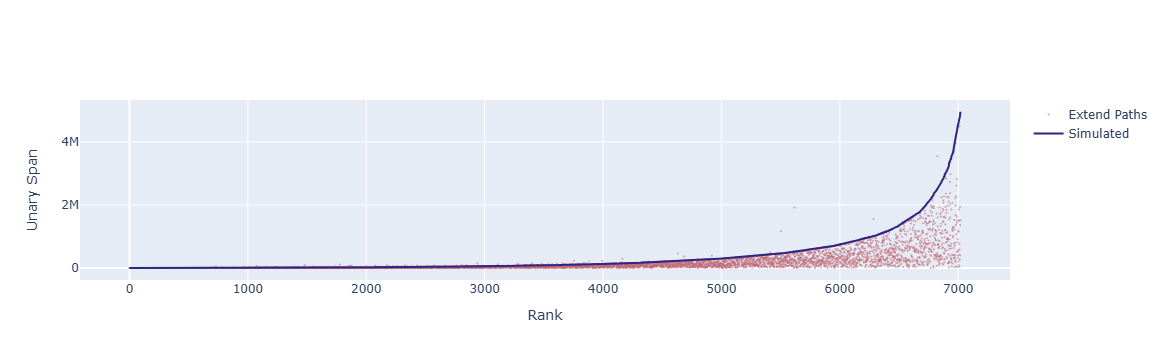

In [10]:
f = go.Figure()
f.add_trace(go.Scatter(x=np.arange(order.size), y=out1[order, 1], name='Extend Paths', mode='markers', marker=dict(opacity=0.6, size=2, color=colors['red']))
           )
f.add_trace(go.Scatter(x=np.arange(order.size), y=out0[order, 1], name="Simulated", mode='lines', marker=dict(color=colors['blue'])))
f.update_xaxes(title='Rank')
f.update_yaxes(title='Unary Span')
f.show()
plotly.io.write_image(f, 'paper/newplots_wo_ee/better_unary_spans_ep_notlog.pdf', format='pdf')

# Graph Node Spans

In [32]:
from COPYevaluation import node_spans

In [35]:
ts = msprime.sim_ancestry(100, population_size = 1000, sequence_length = 5e7, coalescing_segments_only = False,
                          recombination_rate = 1e-8)
sts = ts.simplify()
ets = sts.extend_paths()
x = np.arange(1,ts.num_nodes+1)
ts_spans = np.sort(node_spans(ts))
sts_spans = np.sort(node_spans(sts))
ets_spans = np.sort(node_spans(ets))

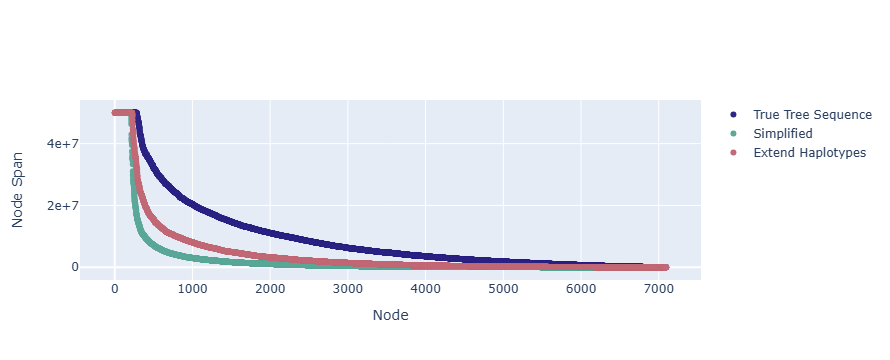

In [16]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x = x, y = ts_spans[::-1], name = 'True Tree Sequence', mode = 'markers', marker=dict(color=colors['blue'])))
fig2.add_trace(go.Scatter(x = x, y = sts_spans[::-1], name = 'Simplified', mode = 'markers', marker=dict(color=colors['lgreen'])))
fig2.add_trace(go.Scatter(x = x, y = ets_spans[::-1], name = 'Extend Haplotypes', mode = 'markers', marker=dict(color=colors['red'])))
fig2.update_layout(xaxis = dict(title='Node'), yaxis = dict(title = 'Node Span', exponentformat='e'))
fig2.show()
# plotly.io.write_image(fig2, 'paper/newplots_wo_ee/node_spans_1e7_ss100.pdf', format='pdf')

### Remove isolated Unary regions

In [36]:
unary_spans = []
for x in [ts, ets, sts]:
    out = edgewise_tally_unary_spans(x)
    sums = out.sum(axis=0)
    total = np.sum(sums[:2])
    props = 100 * np.round(sums / total, 2)
    print(f"Total unary span bordering coalescing: {sums[1]} ({props[1]}%)")
    print(f"Total trapped unary span: {sums[0]} ({props[0]}%)")
    print(f"Total coalescing span: {sums[2]}")
    unary_spans.append(out)


out0, out1, out2 = unary_spans

Total unary span bordering coalescing: 25193790017.0 (51.0%)
Total trapped unary span: 24570577222.0 (49.0%)
Total coalescing span: 9950000000.0
Total unary span bordering coalescing: 12083286371.0 (100.0%)
Total trapped unary span: 0.0 (0.0%)
Total coalescing span: 9950000000.0
Total unary span bordering coalescing: 0.0 (nan%)
Total trapped unary span: 0.0 (nan%)
Total coalescing span: 9950000000.0


/tmp/ipykernel_468/3116629718.py:6: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_468/3116629718.py:6: RuntimeWarning:

invalid value encountered in divide



In [37]:
y0=np.sort(out0[:,1:].sum(axis=1))
y1=np.sort(out1[:,1:].sum(axis=1))
y2=np.sort(out2[:,1:].sum(axis=1))

In [41]:
x = np.arange(1,ts.num_nodes+1)
num_nodes = ts.num_nodes

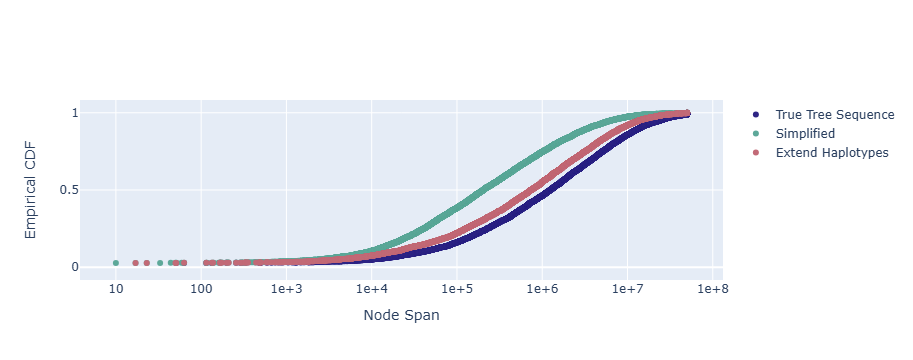

In [67]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x = y0, y = x/num_nodes, name = 'True Tree Sequence', mode = 'markers', marker=dict(color=colors['blue'])))
fig2.add_trace(go.Scatter(x = y2, y = x/num_nodes, name = 'Simplified', mode = 'markers', marker=dict(color=colors['lgreen'])))
fig2.add_trace(go.Scatter(x = y1, y = x/num_nodes, name = 'Extend Haplotypes', mode = 'markers', marker=dict(color=colors['red'])))
fig2.update_layout(xaxis = dict(title='Node Span', exponentformat='e', type='log'), yaxis = dict(title='Empirical CDF',exponentformat='e'))
fig2.show()
plotly.io.write_image(fig2, 'paper/newplots_wo_ee/node_spans_wo_trapped_unary_regions_CDF.pdf', format='pdf')

# Iteration Convergence

1. [ ] Find the number of iterations it takes to run `extend_haplotypes` before convergence. 
2. [ ] Get final edge counts for `tsinfer`, `simulated`, `simulated-simplified`, `infer-simplifed`, `infer-simplified-extended`, `simulated-simplified-extended`, as comparision for edge compression.

Parameters 1e6-5e7 length and samples=1000

### Edge Counts

- Over samples

In [60]:
samplelist = [10, 50, 100, 500, 1000]
lengthlist = [1e6, 5e6, 1e7, 5e7]

sts_edges = np.zeros(len(samplelist))
ets_edges = np.zeros(len(samplelist))
inf_sts_edges = np.zeros(len(samplelist))
inf_ets_edges = np.zeros(len(samplelist))
inf_edges = np.zeros(len(samplelist))
ts_edges = np.zeros(len(samplelist))

' Lets first run the sample experiments '
for i,sample in enumerate(samplelist):
    print(i)
    # ts = msprime.sim_ancestry(sample, population_size=1000, sequence_length=5e7,
    #                               recombination_rate=1e-8, coalescing_segments_only=False)
    ts = tskit.load(f'trees/ts2_{sample}s_5e7')
    ts_edges[i] = ts.num_edges
    sts = ts.simplify()
    ets = sts.extend_paths()
    sts_edges[i] = sts.num_edges
    ets_edges[i] = ets.num_edges

    mutation_rate = 1e-7  # mutation rate for the inferred tree sequences
    ts = msprime.sim_mutations(ts, mutation_rate)
    infer_ts = tsinfer.infer(tsinfer.SampleData.from_tree_sequence(ts))
    t = infer_ts.tables
    t.compute_mutation_times()
    infer_ts = t.tree_sequence()
    infer_ts.dump(f'trees/infer_ts2_{sample}s_5e7')
    print(time())
    infer_sts = infer_ts.simplify()
    infer_ets = infer_sts.extend_paths()
    
    inf_edges[i] = infer_ts.num_edges
    inf_sts_edges[i] = infer_sts.num_edges
    inf_ets_edges[i] = infer_ets.num_edges

0
1728265087.7536643
1
1728265294.797578
2
1728265718.7516558
3
1728268647.4600897
4
1728274293.1963866


In [72]:
ts_edges, sts_edges, ets_edges, inf_sts_edges, inf_ets_edges, inf_edges
np.save('stats/ts_edges_5e7_over_sample.npy', ts_edges)
np.save('stats/sts_edges_5e7_over_sample.npy', sts_edges)
np.save('stats/ets_edges_5e7_over_sample.npy', ets_edges)
np.save('stats/inf_sts_edges_5e7_over_sample.npy', inf_sts_edges)
np.save('stats/inf_ets_edges_5e7_over_sample.npy', inf_ets_edges)
np.save('stats/inf_edges_5e7_over_sample.npy', inf_edges)

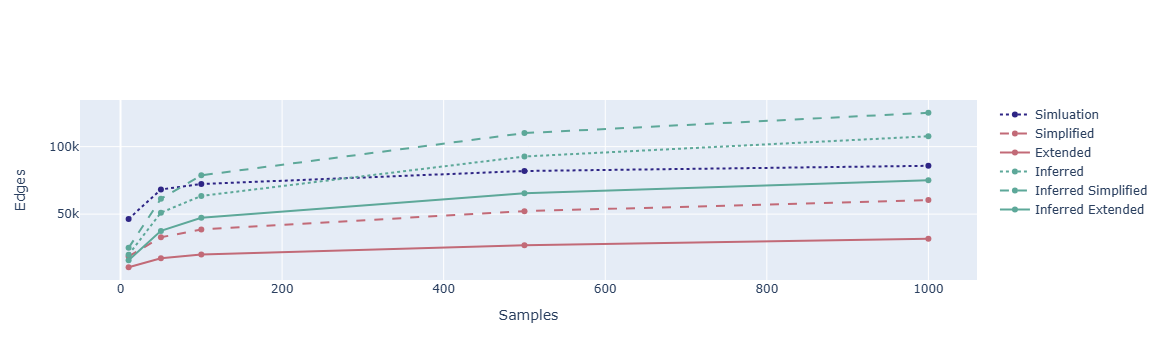

In [71]:
f = go.Figure()
for (data, name, c, dash) in [(ts_edges, 'Simluation', 'blue', 'dot'),
                                        (sts_edges, 'Simplified', 'red','dash'),
                                        (ets_edges, 'Extended', 'red', None),
                                        (inf_edges, 'Inferred', 'lgreen', 'dot'),
                                        (inf_sts_edges, 'Inferred Simplified', 'lgreen', 'dash'),
                                        (inf_ets_edges, 'Inferred Extended', 'lgreen', None)
                                       ]:
    f.add_trace(go.Scatter(
        x = samplelist, y = data, legendgroup = 'original', name=name, line=dict(color=colors[c], dash=dash)
    ))
f.update_layout(
    xaxis=dict(title='Samples'),
    yaxis=dict(title='Edges')
)
f.show()
plotly.io.write_image(f, 'paper/newplots_wo_ee/edge_counts_5e7.pdf', format='pdf')

- over length

In [83]:
samplelist = [10, 50, 100, 500, 1000]
lengthlist = [1e6, 5e6, 1e7, 5e7]
names = ['1e6', '5e6', '1e7', '5e7']
sts_edges = np.zeros(len(samplelist))
ets_edges = np.zeros(len(samplelist))
inf_sts_edges = np.zeros(len(samplelist))
inf_ets_edges = np.zeros(len(samplelist))
inf_edges = np.zeros(len(samplelist))
ts_edges = np.zeros(len(samplelist))

' Lets first run the sample experiments '
for i, (length,name) in enumerate(zip(lengthlist, names)):
    # ts = msprime.sim_ancestry(1000, population_size=1000, sequence_length=length,
    #                               recombination_rate=1e-8, coalescing_segments_only=False)
    ts = tskit.load(f'trees/ts_1000s_{name}')
    print(i)
    ts_edges[i] = ts.num_edges
    sts = ts.simplify()
    ets = sts.extend_paths()
    sts_edges[i] = sts.num_edges
    ets_edges[i] = ets.num_edges

    start = time()
    mutation_rate = 1e-7  # mutation rate for the inferred tree sequences
    ts = msprime.sim_mutations(ts, mutation_rate)
    infer_ts = tsinfer.infer(tsinfer.SampleData.from_tree_sequence(ts))
    t = infer_ts.tables
    t.compute_mutation_times()
    infer_ts = t.tree_sequence()
    print(time()-start)
    infer_ts.dump(f'trees/infer_ts_1000s_{name}')
    infer_sts = infer_ts.simplify()
    infer_ets = infer_sts.extend_paths()
    
    inf_edges[i] = infer_ts.num_edges
    inf_sts_edges[i] = infer_sts.num_edges
    inf_ets_edges[i] = infer_ets.num_edges

0
27.50821828842163
1
243.69151043891907
2
678.7219662666321
3
7011.374032258987


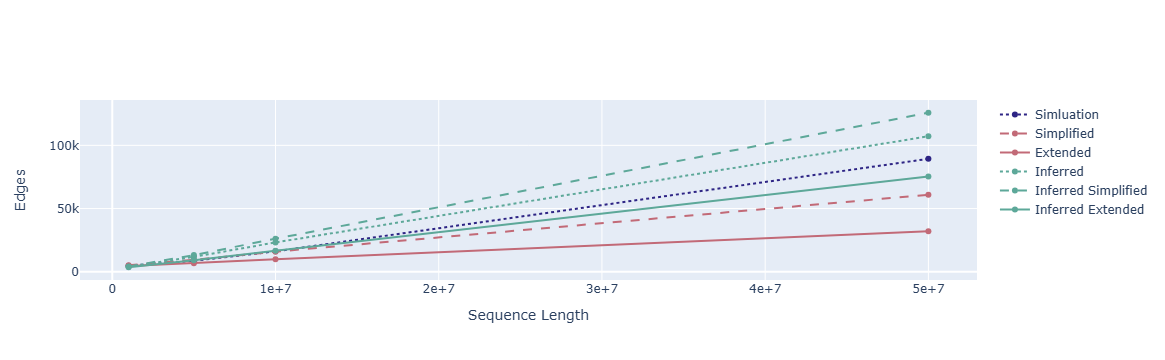

In [89]:
f = go.Figure()
for (data, name, c, dash) in [(ts_edges, 'Simluation', 'blue', 'dot'),
                                        (sts_edges, 'Simplified', 'red','dash'),
                                        (ets_edges, 'Extended', 'red', None),
                                        (inf_edges, 'Inferred', 'lgreen', 'dot'),
                                        (inf_sts_edges, 'Inferred Simplified', 'lgreen', 'dash'),
                                        (inf_ets_edges, 'Inferred Extended', 'lgreen', None)
                                       ]:
    f.add_trace(go.Scatter(
        x = lengthlist, y = data, legendgroup = 'original', name=name, line=dict(color=colors[c], dash=dash)
    ))
f.update_layout(
    xaxis=dict(title='Sequence Length', exponentformat='e'),
    yaxis=dict(title='Edges')
)
f.show()
plotly.io.write_image(f, 'paper/newplots_wo_ee/edge_counts_1000s.pdf', format='pdf')

### Iteration Convergence

In [ ]:
samplelist = [1000, 10000]
# lengthlist = [1e7, 5e7, 1e8]
# names = ['1e7', '5e7', '1e8']
for sample in samplelist:
    for length, name in zip([1e7, 5e7], ['1e7', '5e7']):
        print('----------------------', sample, length, '-------------------------')
        if (sample == 1000 and length == 5e7) or (sample == 1000 and length == 1e7):
            continue
        convergence_times = np.zeros(50)
        i=0
        edges_list = []
        reps = msprime.sim_ancestry(sample, population_size=1000, sequence_length=length, recombination_rate=1e-8, coalescing_segments_only=False, num_replicates=50)
        for ts in reps:
            sts = ts.simplify()
            e_list = []
            e_list.append(sts.num_edges)
            old_num_edges = 0
            new_num_edges = sts.num_edges
            iteration = 0
            print(i)
            while old_num_edges != new_num_edges:
                old_num_edges = new_num_edges
                ets = sts.extend_paths(max_iter=1)
                iteration += 1
                e_list.append(ets.num_edges)
                new_num_edges = ets.num_edges
                sts = ets
            edges_list.append(e_list)
            convergence_times[i] = iteration
            i += 1
        max_iter = int(np.max(convergence_times)) + 1
        edges_per_iter = np.zeros((50, max_iter))
        for j,e in enumerate(edges_list):
            e_list = e
            l = len(e_list)
            if l != max_iter:
                n = max_iter-l
                for _ in range(n):
                    e_list.append(e_list[-1])
            assert len(e_list) == max_iter, print(j,e_list)
            edges_per_iter[j] = e_list
        np.save(f'stats/edges_per_iter_{name}_{sample}s.npy', edges_per_iter)
        np.save(f'stats/convergence_times_{name}_{sample}s.npy', convergence_times)

---------------------- 1000 10000000.0 -------------------------
---------------------- 1000 50000000.0 -------------------------
---------------------- 10000 10000000.0 -------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
---------------------- 10000 50000000.0 -------------------------
0
1
2
3


In [4]:
convergence_times, edges_list

(array([4., 4., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 [[113463, 76301, 76059, 76057, 76057],
  [113266, 76084, 75835, 75833, 75833],
  [114489, 76703, 76436, 76434, 76434],
  [114086, 76550, 76294, 76291, 76291]])

In [ ]:
ss = np.load('stats/convergence_times_1e7_1000s.npy')
sl = np.load('stats/convergence_times_1e7_10000s.npy')
ms = np.load('stats/convergence_times_5e7_1000s.npy')
ml = np.load('stats/convergence_times_5e7_10000s.npy')
ls = np.load('stats/convergence_times_1e8_1000s.npy')
ll = np.load('stats/convergence_times_1e8_10000s.npy')

[4. 4. 4. 4. 3. 3. 4. 4. 4. 3. 4. 4. 4. 4. 3. 4. 3. 5. 4. 4. 4. 3. 3. 4.
 4. 4. 3. 3. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 4. 4. 3. 3. 3. 4. 3. 3.
 3. 4.] 3.58


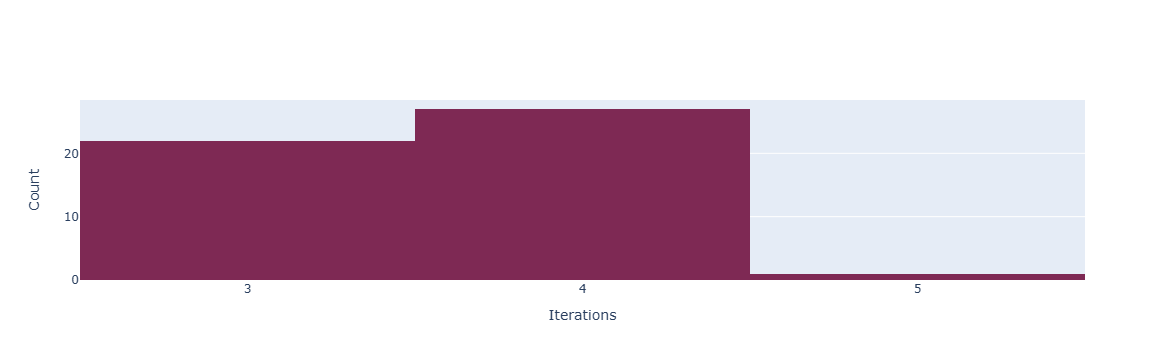

In [38]:
f = go.Figure()
for (convergence_times, group, name, color, pattern) in [(ss, '1000 Samples', 'Length 1e7', colors['blue'], None),
                                                         (sl, '10000 Samples', 'Length 1e7', colors['blue'], '.'),
                                                         (ms, '1000 Samples', 'Length 5e7', colors['wine'], None]),
                                                         (ml, '10000 Samples', 'Length 5e7', colors['wine'], '.'),
                                                         (ls, '1000 Samples', 'Length 1e8', colors['gold'], None),
                                                         (ll, '10000 Samples', 'Length 1e8', colors['gold'], '.')]:
    f.add_trace(go.Histogram(x=convergence_times, marker_color=color, legendgroup=group, name=name, marker_pattern_shape=pattern))
f.update_layout(
    xaxis = dict(
        title = 'Iterations',
        tickmode = 'array',
        tickvals = [3, 4, 5],
    ),
    yaxis = dict( title='Count')
)
# Overlay both histograms
f.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
f.update_traces(opacity=0.75)
f.show()

In [ ]:
ss = np.load('stats/edges_per_iter_1e7_1000s.npy')
sl = np.load('stats/edges_per_iter_1e7_10000s.npy')
ms = np.load('stats/edges_per_iter_5e7_1000s.npy')
ml = np.load('stats/edges_per_iter_5e7_10000s.npy')
ls = np.load('stats/edges_per_iter_1e8_1000s.npy')
ll = np.load('stats/edges_per_iter_1e8_10000s.npy')

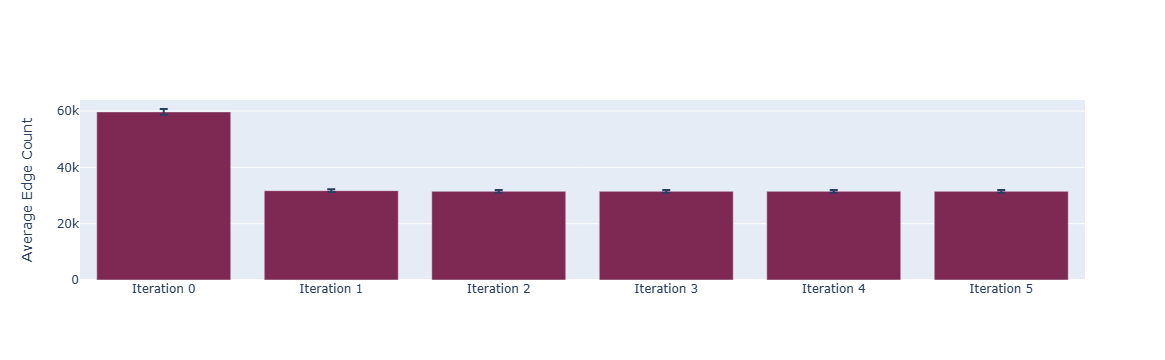

In [55]:
fig = go.Figure()
for (edges_per_iter, group, name, color, pattern) in [(ss, '1000 Samples', 'Length 1e7', colors['blue'], None),
                                                         (sl, '10000 Samples', 'Length 1e7', colors['blue'], 'dash'),
                                                         (ms, '1000 Samples', 'Length 5e7', colors['wine'], None]),
                                                         (ml, '10000 Samples', 'Length 5e7', colors['wine'], 'dash'),
                                                         (ls, '1000 Samples', 'Length 1e8', colors['gold'], None),
                                                         (ll, '10000 Samples', 'Length 1e8', colors['gold'], 'dash')]:

    fig.add_trace(go.Scatter(x=np.arange(6),
                     y = np.average(edges_per_iter, axis=0),
                     line = dict(color=color, dash=pattern)
                     name=name,
                     legendgroup=group,
                     error_y=dict(type='data', array=np.std(edges_per_iter, axis=0))))
fig.update_layout(yaxis=dict(title='Average Edge Count'))
fig.show()
plotly.io.write_image(fig, 'paper/newplots_wo_ee/avg_edge_count_over_iters_5e7_1000s.pdf', format='pdf')

In [44]:
np.mean(edges_per_iter, axis=0), np.std(edges_per_iter, axis=0)

(array([59687.12, 31714.52, 31479.56, 31478.42, 31478.4 , 31478.4 ]),
 array([1025.78650098,  496.4837657 ,  492.48078785,  492.44021322,
         492.48573583,  492.48573583]))